# Solving the CC-PAP in a finite A and finite $\mathcal{X}$ instance

In [1]:
# imports

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

Let us work on the instance on which we successfully solved the discrete PAP

- $A = \{1,2,4,6\}$
- $\mathcal{X} = \{1,2,3,4,5\}$
- $\forall x \in \mathcal{X},\, \forall a \in A, \quad F(x|a) = \mathbb{P}^a[X \leq x] = (\frac{x}{5})^a$
-
$$
\begin{cases}
U_A(s,a) = u(s) - a^2\\
U_P(x,s) = x - s
\end{cases}
$$
-
$$
u \colon \left | \begin{matrix}
\mathbb{R}_+^* \to \mathbb{R}_-^*\\
w \mapsto -\frac{1}{\sqrt{w}}
\end{matrix} \right.
$$
-
$$
u^{-1} = \phi \colon \left | \begin{matrix}
\mathbb{R}_-^* \to \mathbb{R}_+^*\\
v \mapsto \frac{1}{v^2}
\end{matrix} \right.
$$

Let us copy some useful objects and functions from the previous notebook

In [2]:
# bounds and parameters of the problem

set_a = [1,2,4,6]
set_x = [1,2,3,4,5]
extended_set_x = np.arange(max(set_x)+1)
max_set_x = max(set_x)

bounds = sp.optimize.Bounds(lb=len(set_x)*[-np.inf], ub = len(set_x)*[-1e-9])

In [3]:
def prob_vect(a):
    cdf_vect = (extended_set_x/max_set_x)**a
    return cdf_vect[1:]-cdf_vect[:-1]

We will reuse `get_agent_rationality_const` and `get_expected_up_function`

In [4]:
def get_agent_rationality_const(i:int):

    other_a_list = []

    for j in range(len(set_a)):
        if j != i:
            other_a_list.append(j)

    matrix = np.stack([prob_vect(set_a[i]) - prob_vect(set_a[i_a]) for i_a in other_a_list])

    return sp.optimize.LinearConstraint(
                A = matrix,
                lb = [set_a[i]**2 - set_a[i_a]**2 for i_a in other_a_list]
    )

In [5]:
def get_expected_up_function(a):
    return lambda v:np.dot(prob_vect(a),np.pow(v,-2))

We have defined everything to solve our problem. Let us use a solver

## Solving the PAP (once again)

First, let us write a function that solves all the subproblems of the PAP

In [6]:
def solve_full_pap(R0):

    # solving |A| different instances of the problem

    current_max = -np.inf
    current_res = None
    current_i_a = -1

    for i in range(len(set_a)):

        const_list = [sp.optimize.LinearConstraint(
        A = prob_vect(set_a[i]),
        lb = [R0 + set_a[i]**2]
        )]

        const_list.append(get_agent_rationality_const(i))

        # we will solve each subproblem twice (to improve numerical stability)

        for _ in range(5):

            init = np.random.randn(len(set_x)) + 5*np.ones(len(set_x))

            res = sp.optimize.minimize(fun = get_expected_up_function(set_a[i]), bounds=bounds,
                                        x0 = init,method="trust-constr",constraints=const_list,
                                        options={"factorization_method":"SVDFactorization"})

            benef_principal = np.dot(np.array(set_x),prob_vect(set_a[i]))

            if (benef_principal - res.fun > current_max) and (res.success == True):
                current_max = benef_principal - res.fun
                current_res = res
                current_i_a = i

    return current_res,current_i_a


To assess its well-working, let us compare its result for $R_0 = -30$ with the solution found at the end of `pap_cfdc.ipynb`

In [7]:
res,i_a = solve_full_pap(-30)
print(res)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 0.005476342569531141
                 x: [-3.230e+02 -1.436e+01 -1.369e+01 -1.351e+01 -1.344e+01]
               nit: 152
              nfev: 942
              njev: 157
              nhev: 0
          cg_niter: 262
      cg_stop_cond: 4
              grad: [ 9.515e-11  1.622e-05  8.113e-05  2.272e-04  4.868e-04]
   lagrangian_grad: [ 1.015e-09 -1.091e-09 -2.334e-09  3.609e-09 -1.259e-09]
            constr: [array([-1.400e+01]), array([ 6.160e+01,  1.200e+01, -5.140e-01]), array([-3.230e+02, -1.436e+01, -1.369e+01, -1.351e+01,
                           -1.344e+01])]
               jac: [array([[ 1.600e-03,  2.400e-02,  1.040e-01,
                             2.800e-01,  5.904e-01]]), array([[-1.984e-01, -1.760e-01, ...,  8.000e-02,
                             3.904e-01],
                           [-3.840e-02, -9.600e-02, ..., -5.551e-17,
                

Indeed, it is the same solution than in the previous notebook.

$\forall w \in \mathbb{R}_+^*, \, \forall a \in A, \, U_A(w,a) < 0$, thus by decrease of $R_0 \mapsto F_1(R_0)$, it exists $\tilde{R_0}$ such that
$$
\{ R_0 \in \mathbb{R} \, | \, F_1 (R_0) \cap F_2 \neq \emptyset \} = \begin {cases}
]-\infty,\tilde{R_0}[\\
\text{or}\\
]-\infty,\tilde{R_0}]
\end{cases}
$$

Let us compute an approximation of $\tilde{R_0}$

In [8]:
for R0 in [-10,-5,-3,-2,-1]:
    print(f"R0 = {R0}")
    res,i_a = solve_full_pap(R0)
    if res != None:
        print(res.success)
        print(f"utilities = {res.x}")
        print(f"wages = {np.pow(res.x,-2)}")
        print(f"avg Ua = {np.dot(prob_vect(set_a[i_a]),res.x) - set_a[i_a]**2}")
    else:
        print("Unfeasible problem")
    print()

R0 = -10


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-23.66930835  -5.65513539  -5.32572253  -5.20595773  -5.14388096]
wages = [0.00178496 0.031269   0.0352568  0.03689765 0.03779359]
avg Ua = -9.999998396635748

R0 = -5


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-3.99999938 -3.99999955 -3.99999968 -3.99999978 -3.99999996]
wages = [0.06250002 0.06250001 0.06250001 0.06250001 0.0625    ]
avg Ua = -4.999999672318925

R0 = -3


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-1.99999995 -1.99999995 -1.99999995 -1.99999996 -1.99999999]
wages = [0.25000001 0.25000001 0.25000001 0.25000001 0.25      ]
avg Ua = -2.999999959039942

R0 = -2


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-1.         -1.         -1.         -1.         -0.99999999]
wages = [1.00000001 1.00000001 1.00000001 1.00000001 1.00000002]
avg Ua = -1.999999994879999

R0 = -1


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

Unfeasible problem



We have shown that $-2 \leq \tilde{R_0} \leq -1$. We can therefore safely plot the solution of the PAP for $R_0 \in [-30,-2]$

In [9]:
R0_list = np.linspace(-30,-2,20)
res_list_1 = []
i_max_list_1 = []
up_avg_list_1 = []

for i in range(len(R0_list)):
    res,i_max = solve_full_pap(R0_list[i])
    res_list_1.append(res)
    i_max_list_1.append(i_max)
    up_avg_list_1.append(np.dot(set_x,prob_vect(set_a[i_max])) - res.fun)


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

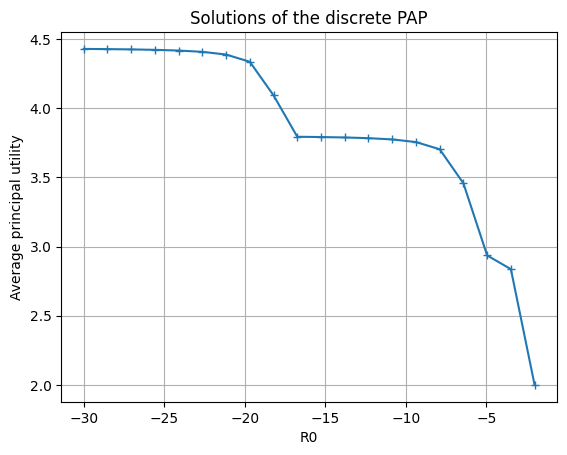

In [10]:
plt.title("Solutions of the discrete PAP")

plt.plot(R0_list,up_avg_list_1,marker="+")

plt.grid()
plt.xlabel("R0")
plt.ylabel("Average principal utility")

plt.show()

The principal utility is a decreasing function of $R_0$, which is guaranteed by the theory. It makes us confident in the well-working of our code.

## Solving the ethical CC-PAP

Now that we are confident with the well-working of the PAP, let us solve the ethical CC-PAP. For computational reasons, we start by this problem (it has 5 subproblems instead of 31).

In [11]:
# constraint enforcing increasing wages

monot_const_mat = np.zeros((len(set_x)-1,len(set_x)))

for i in range(len(set_x)-1):

    monot_const_mat[i,i] = -1
    monot_const_mat[i,i+1] = 1

monot_const = sp.optimize.LinearConstraint(
    A = monot_const_mat,
    lb = np.zeros(len(set_x)-1),
    ub = (len(set_x)-1) * [np.inf]
)

In [ ]:
def solve_ethical_cc_pap(R1,alpha,other_init=False,loc_init=-np.ones(len(set_x)),num_sol=1):

    # solving |A| * |X| * num_sol different instances of the problem

    # experimentally, the optimal point is close to this initial value 
    # for big R1 values, which are the toughest to handle

    if other_init:
        init = loc_init
    else:
        init = np.ones(len(set_x))*(R1+1)

    current_max = -np.inf
    current_res = None
    current_i_a = -1

    for i in range(len(set_a)):

        const_list = [get_agent_rationality_const(i),monot_const]

        for j in range(len(set_x)):

            feasible = False

            if j == 0:

                feasible = True

                matrix = np.zeros(len(set_x))
                matrix[0] = 1

                const_list.append(sp.optimize.LinearConstraint(
                    A = matrix,
                    lb = R1 + set_a[i]**2
                ))

            elif np.pow(set_x[j-1]/max_set_x,set_a[i]) <= alpha:

                feasible = True

                matrix = np.zeros((2,len(set_x)))
                matrix[0,j-1] = 1
                matrix[1,j] = 1

                const_list.append(sp.optimize.LinearConstraint(
                    A = matrix,
                    lb = [-np.inf,R1 + set_a[i]**2],
                    ub = [R1 + set_a[i]**2,np.inf]
                ))


            if feasible:

                for _ in range(num_sol):

                    res = sp.optimize.minimize(fun = get_expected_up_function(set_a[i]), bounds=bounds,
                                                x0 = init,method="trust-constr",constraints=const_list,
                                                options={"factorization_method":"SVDFactorization"})

                    benef_principal = np.dot(np.array(set_x),prob_vect(set_a[i]))

                    if (benef_principal - res.fun > current_max) and (res.success == True):
                        current_max = benef_principal - res.fun
                        current_res = res
                        current_i_a = i

    return current_res,current_i_a

In [13]:
res,imax = solve_ethical_cc_pap(R1=-10,alpha=0.05)
a = set_a[imax]
prob = prob_vect(a)

print(f"a = {a}")
print(f"x = {res.x}")
print(f"Average Up = {res.fun : 1.3f}")
print()
print(res)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

a = 1
x = [-8.99950035 -8.99917123 -8.99840366 -8.99669792 -8.99476208]
Average Up =  0.012

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 0.012351973512830407
                 x: [-9.000e+00 -8.999e+00 -8.998e+00 -8.997e+00 -8.995e+00]
               nit: 21
              nfev: 84
              njev: 14
              nhev: 0
          cg_niter: 24
      cg_stop_cond: 4
              grad: [ 5.488e-04  5.488e-04  5.490e-04  5.493e-04  5.497e-04]
   lagrangian_grad: [ 4.606e-11 -1.372e-10 -1.484e-10  8.670e-10  4.499e-10]
            constr: [array([-9.560e-04, -1.911e-03, -2.355e-03]), array([ 3.291e-04,  7.676e-04,  1.706e-03,  1.936e-03]), array([-9.000e+00]), array([-9.000e+00, -8.999e+00, -8.998e+00, -8.997e+00,
                           -8.995e+00])]
               jac: [array([[ 1.600e-01,  8.000e-02, ..., -8.000e-02,
                            -1.600e-01],
                           [ 1.984e-01

To check this solution, we will compute the average agent utility for $\texttt{res.x}$ and all values of $a$, and $\mathbb{P}^a [U_A(w(X),a) \geq R_0]$

In [14]:
def get_expected_ua_orig_variables(a):
    return lambda w:np.dot(prob_vect(a),-np.pow(w,-0.5))-a**2

for i in range(len(set_a)):
    print(f"a = {set_a[i]}")
    print(f"Utility = {get_expected_ua_orig_variables(set_a[i])(np.pow(res.x,-2))}")
    print()

opt_prob_vect = prob_vect(set_a[imax])
prob_higher = np.sum(
    opt_prob_vect * (res.x >= -10 - 1e-4)
)
print(f"probability Ua >= R0 = {prob_higher}")

a = 1
Utility = -9.997707049627499

a = 2
Utility = -12.996751062414376

a = 4
Utility = -24.99579624410662

a = 6
Utility = -44.995352301282324

probability Ua >= R0 = 1.0


The solution we have found satisfies both constraints, which is encouraging.

Like the PAP, let us define $\tilde{R_1}(\alpha)$ by
$$
\{ R_0 \in \mathbb{R} \, | \text{the ethical CC-PAP of parameters } (R_0,\alpha) \text{ is feasible} \} = \begin {cases}
]-\infty,\tilde{R_1}(\alpha)[\\
\text{or}\\
]-\infty,\tilde{R_1}(\alpha)]
\end{cases}
$$

Let us compute an approximation of $\tilde{R_1}(0.95)$

In [15]:
for R1 in [-10,-5,-3,-2]:
    print(f"R1 = {R1}")
    res,i_a = solve_ethical_cc_pap(R1,alpha=0.05)
    if res != None:
        print(res.success)
        print(f"utilities = {res.x}")
        print(f"wages = {np.pow(res.x,-2)}")
        print(f"avg Ua = {np.dot(prob_vect(set_a[i_a]),res.x) - set_a[i_a]**2}")
    else:
        print("Unfeasible problem")
    print()

R1 = -10


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-8.99950035 -8.99917123 -8.99840366 -8.99669792 -8.99476208]
wages = [0.01234705 0.01234795 0.01235006 0.01235474 0.01236006]
avg Ua = -9.997707049627499

R1 = -5


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-3.99978    -3.99924846 -3.99913674 -3.99876049 -3.99720577]
wages = [0.06250688 0.06252349 0.06252699 0.06253875 0.06258741]
avg Ua = -4.998826292052333

R1 = -3


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-1.99986092 -1.99969593 -1.99948478 -1.99917251 -1.99842012]
wages = [0.25003477 0.25007603 0.25012885 0.250207   0.25039544]
avg Ua = -2.999326850592241

R1 = -2


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

True
utilities = [-0.9999878  -0.99997351 -0.9999389  -0.99989916 -0.99980283]
wages = [1.00002441 1.00005298 1.00012221 1.0002017  1.00039446]
avg Ua = -1.9999204396502919



This code cell shows us that $\tilde{R_1}(0.95) \geq -2$.

More rigorously, we can point out that for $R_1 < -1$, we can take $v = (R_1+1, \dots, R_1+1)$ and $a = 1$. For any $b \in A$ the average agent utility in $v,b$ is $R_1 + 1 - b^2$ : this function of $b$ is maximal in $1$. Moreover, the average agent utility in $v,a$ is equal to $R_1$ a.s., which verifies the probability constraint for any $\alpha$.

Thus, $\forall \alpha \in [0,1], \, \tilde{R_1}(\alpha) \geq -1$. We can thus safely solve the CC-PAP of any $R_1 \leq -2$

In [16]:
R1_list = np.concatenate((np.linspace(-30,-5,10),np.array([-4,-3,-2])))
alpha_list = [0.05,0.1,0.5]

res_array = []
i_max_array = []
up_avg_array = []


for i in range(len(R1_list)-1,-1,-1):

    res_list_fixed_R1 = []
    i_max_list_fixed_R1 = []
    up_avg_list_fixed_R1 = []

    for j in range(len(alpha_list)):

        print()
        print(f"i,j = {i},{j}")
        print()

        res,i_max = solve_ethical_cc_pap(R1=R1_list[i],alpha=alpha_list[j])



        res_list_fixed_R1.append(res)
        i_max_list_fixed_R1.append(i_max)
        if res != None:
            up_avg_list_fixed_R1.append(np.dot(set_x,prob_vect(set_a[i_max])) - res.fun)
        else:
            print("unsuccessful optimization")
            up_avg_list_fixed_R1.append(-2)

    res_array.append(res_list_fixed_R1)
    i_max_array.append(i_max_list_fixed_R1)
    up_avg_array.append(up_avg_list_fixed_R1)

res_array.reverse()
i_max_array.reverse()
up_avg_array.reverse()



i,j = 12,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 12,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 12,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 11,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 11,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 11,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 10,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 10,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 10,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 9,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 9,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 9,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 8,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 8,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 8,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 7,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 7,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 7,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 6,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 6,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 6,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 5,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 5,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 5,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 4,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 4,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 4,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 3,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 3,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 3,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 2,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 2,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 2,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 1,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 1,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 1,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 0,0



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 0,1



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua


i,j = 0,2



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using qua

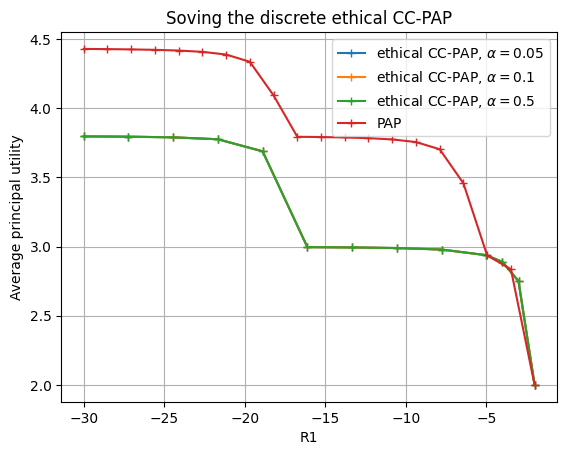

In [18]:
plt.title("Soving the discrete ethical CC-PAP")

up_avg_ndarray = np.array(up_avg_array)

label_list = [f"ethical CC-PAP, $\\alpha=${a}" for a in alpha_list]

plt.plot(R1_list,up_avg_array,marker="+",label=label_list)
plt.plot(R0_list,up_avg_list_1,marker="+",label="PAP")

plt.xlabel("R1")
plt.ylabel("Average principal utility")
plt.legend()

plt.grid()

plt.show()